# Demonstração de Onion Routing

Este notebook busca demonstrar de forma legível o sistema de Onion Routing apresentado na matéria de Segurança da Informação acompanhada da apostila de "Programando a própria Onion Routing".




## Funções auxiliares

Ao longo desta demonstração utilizarei algumas funções auxiliares responsáveis por gerar chaves privadas, usá-las para criptografia, desencriptação e etc. Utilizarei também bibliotecas auxiliares de python como a Crypto e a cryptography.

In [ ]:
!pip install cryptography pycrypto pycryptodome

     |████████████████████████████████| 3.2MB 12.8MB/s 
     |████████████████████████████████| 450kB 38.7MB/s 
     |████████████████████████████████| 1.9MB 38.0MB/s 
  Created wheel for pycrypto: filename=pycrypto-2.6.1-cp37-cp37m-linux_x86_64.whl size=499931 sha256=d93c5e23f20d1971c78046a42e16fa709169b2426f29635553af20b8582311c2
  Stored in directory: /root/.cache/pip/wheels/27/02/5e/77a69d0c16bb63c6ed32f5386f33a2809c94bd5414a2f6c196
Successfully built pycrypto


### Funções auxiliares de criptografia assimétrica

Vou definir 3 funções uteis para criptografia assimétrica:

- Geração de chave privada (Com ela podemos gerar uma chave pública para criptografar mensagens e descriptografar mensagens geradas por suas chaves públicas);
- Criptografar mensagens a partir de chaves públicas;
- Descriptografar mensagens a partir de chaves privadas;

In [ ]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes

PUBLIC_EXPONENT = 65537
KEY_SIZE = 512
ENCODE_TYPE = 'utf-8'

def generate_private_key():
  private_key = rsa.generate_private_key(public_exponent = PUBLIC_EXPONENT,
                                         key_size = KEY_SIZE,
                                         backend = default_backend())
  return private_key

def encrypt(public_key, message):
  encrypted_message = public_key.encrypt(message, padding.OAEP(
      mgf=padding.MGF1(algorithm=hashes.SHA1()),
      algorithm=hashes.SHA1(),
      label=None))
  return encrypted_message

def decrypt(crypt, private_key):
    msg = private_key.decrypt(crypt, padding.OAEP(
                              mgf=padding.MGF1(algorithm=hashes.SHA1()),
                              algorithm=hashes.SHA1(),
                              label=None))
    return msg

In [ ]:
# Teste:
private_key = generate_private_key()
public_key = private_key.public_key()
message = 'test message'
encrypted_message = encrypt(public_key, message.encode(ENCODE_TYPE))
print('encrypted message')
print(encrypted_message)
decrypted_message = decrypt(encrypted_message, private_key)
print('decrypted message')
print(decrypted_message)

encrypted message
b't4>c\xbf\x00\xa4\xa9)\x917\\\x14\xa0%\x16\xe0S\xf8S\xd6"I\xf22\xc6\x17\xa57A\'E\x13\xa5\x85\xd3\xd6\xcd\xadj\xea\xa5\x9a\xd1\xd9\x80dO\xf4K\x04\x9f{_\x8br\xbd\x963\x8b\xa0w\xb3\x04'
decrypted message
b'test message'


### Funções auxiliares de criptografia simétrica

Vamos precisar criar 3 funções similares de criptografia assimétrica para a simétrica:

- Gerar uma chave simétrica
- Criptografar uma mensagem
- Descriptografar uma mensagem

In [ ]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad
from base64 import b64encode
import json

def generate_shared_secret():
  key = get_random_bytes(16)
  return key

def encrypt_AES_message(secret, message):
  cipher = AES.new(secret, AES.MODE_CBC)
  padded_message = pad(message, AES.block_size)
  ct_bytes = cipher.encrypt(padded_message)
  iv = cipher.iv
  return ct_bytes, iv

def decrypt_AES_message(secret, ciphertext, iv):
  cipher = AES.new(secret, AES.MODE_CBC, iv)
  pt = unpad(cipher.decrypt(ciphertext), AES.block_size)
  return pt

In [ ]:
# Teste
shared_key = generate_shared_secret()
message = b"AES message"
encrypted_message, tag = encrypt_AES_message(shared_key, message)
print(encrypted_message, tag)
decrypted_message = decrypt_AES_message(shared_key, encrypted_message, tag)
print(decrypted_message)

b'\xc81\xc2\x8e\x99\xed\xeb\xf6\x12u\xe3\x96\xef\xf6\x029' b'\xee1\xfb\\\x87\xf2KY\x14\xc2\xd2\xf9\x0c\xf9T\xeb'
b'AES message'


### Serialização e desserialização de chaves

Como vamos enviar, criptografar e decriptografar chaves, é importante ter funções que facilitem a sua serialização e desserialização:


In [ ]:
from cryptography.hazmat.primitives import serialization

def deserialize_public_key(public_key):
    deserialized_key = public_key.public_bytes(encoding=serialization.Encoding.PEM,
                                                 format=serialization.PublicFormat.SubjectPublicKeyInfo)
    return deserialized_key

def load_public_key(deserialized_public_key):
    public_key = serialization.load_pem_public_key(deserialized_public_key, default_backend())
    return public_key

In [ ]:
# Teste
deserialized_public_key = deserialize_public_key(public_key)
print(deserialized_public_key)
loaded_public_key = load_public_key(deserialized_public_key)
print(loaded_public_key)

b'-----BEGIN PUBLIC KEY-----\nMFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBAMMKAvT6EeWMhgkT7MvZTP/2csC1lalf\neEfieLR6elpWXOXiFbUCOtHOSwTAq4hB69683KgkUgpyQSOTdp4GfBMCAwEAAQ==\n-----END PUBLIC KEY-----\n'


## Descrevendo o cenário

Para os primeiros passos, vamos falar de um cenário hipotético em que Alice decide enviar uma mensagem para Bob e gostaria de garantir o seu anonimato e de Bob, bem como garantir o sigilo da mensagem se utilizando de uma Rede que se utiliza de Onion Routing. Ao consultar a lista de possíveis caminhos, ela decide por um caminho e adquire a chave pública de cada um dos nós intermediários. Vamos gerar 4 chaves privadas e então retornar a chave pública delas para Alice:

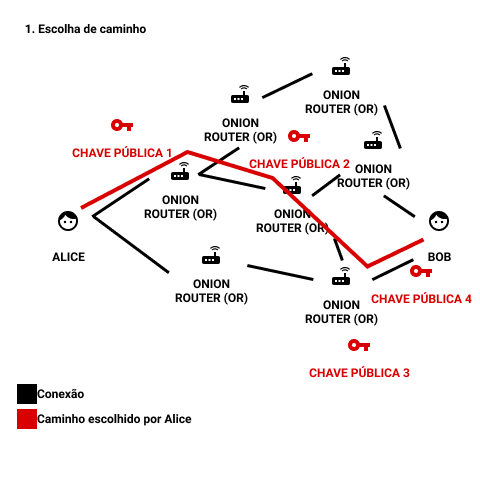

In [ ]:
private_keys = []
for i in range(4):
  private_keys.append(generate_private_key())

public_keys = []
for private_key in private_keys:
  public_keys.append(private_key.public_key())


## Obtendo as chaves compartilhadas

O próximo passo é obter as chaves compartilhadas de cada nó.

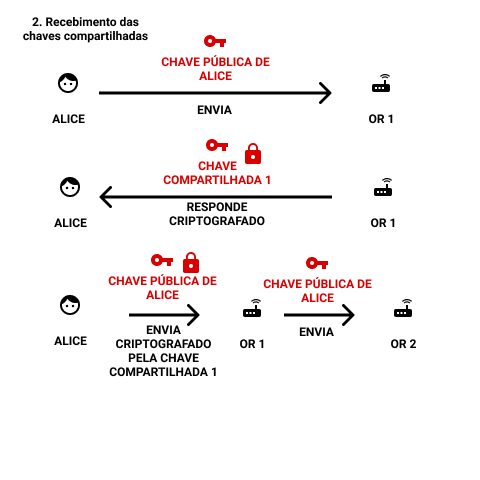

Vamos adotar os endereços de IP de cada nó arbitrariamente como 0, 1, 2 e 3 (sendo Bob o 3). Vamos montar a cebola com a mensagem "Oi Bob!".

In [ ]:
alice_private_key = generate_private_key()
alice_public_key = alice_private_key.public_key()

# Alice vai guardar suas chaves compartilhadas nesta lista
shared_secrets = []
# Alice envia sua chave pública para o Onion Router 1 pedindo por um segredo compartilhado
OR1_shared_secret = generate_shared_secret()
crypted_OR1_ss = encrypt(alice_public_key, OR1_shared_secret)
# OR 1 envia a chave compartilhada para alice. Ela por sua vez consegue descriptografar
shared_secrets.append(decrypt(crypted_OR1_ss, alice_private_key))

# Alice vai repetir o procedimento, mas encriptando a mensagem com o segredo compartilhado que OR1 compartilhou com ela:
shared_secret_request_for_OR2 = json.dumps({
    "public_key" : deserialize_public_key(alice_public_key).decode(ENCODE_TYPE),
    "to" : 1
})

encrypted_request_OR2, iv_OR1 = encrypt_AES_message(shared_secrets[0], shared_secret_request_for_OR2.encode(ENCODE_TYPE))

# Ao desempacotar a requisição, quando OR1 mandar para OR2, OR2 vai interpretar como se fosse uma chamada iniciadora de comunicação qualquer. Pode ser que o pedido estivesse vindo de uma agente como Alice ou de um roteador.
decrypted_request_OR2 = decrypted_request_OR2 = decrypt_AES_message(shared_secrets[0], encrypted_request_OR2, iv_OR1)
print (decrypted_request_OR2)

b'{"public_key": "-----BEGIN PUBLIC KEY-----\\nMFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBAMPbwyqUrW3WZEIfuyhm597OuErVSRUh\\ncZfPPHY/SYVuOzGy/E2B9zctq0sE6PNF25l0eoqUSiGTDsmpbOtIUX0CAwEAAQ==\\n-----END PUBLIC KEY-----\\n", "to": 1}'


Assim, cada OR vai respondendo com uma chave de criptografia simétrica para Alice enquanto cada OR não sabe se quem enviou a mensagem para si foi um usuário inicial ou apenas mais um OR até chegar no Bob.

## Etapa de envio de mensagem

Agora que passamos pela etapa de Setup da comunicação em que Alice obtém as chaves compartilhadas para cada nó da comunicação, agora ela é capaz de montar uma cebola.

Cada camada de uma cebola consiste de uma cebola embarcada e um endereço para o próximo usuário. A única exceção é o destinatário, pois a cebola que ele descriptografar vai se tratar do dado desejado propriamente.

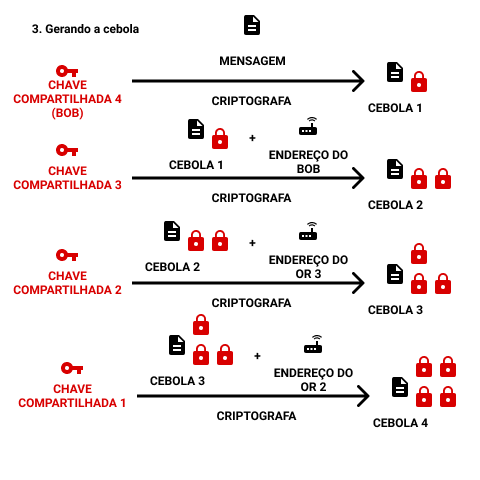

Vamos definir a função responsável pela adição de camada de cebola.

In [ ]:
def add_onion_layer(onion, destiny, shared_secrets):
  new_message = json.dumps({
      "onion": str(onion),
      "destiny": destiny
  })
  new_onion, iv = encrypt_AES_message(shared_secrets, new_message.encode(ENCODE_TYPE))
  return new_onion, iv

Para este cenário, vamos já inicializar o nosso vetor de chaves compartilhadas como se Alice já tivesse passado pela etapa de setup:

In [ ]:
shared_secrets = []

for i in range(4): 
  shared_secrets.append(generate_shared_secret())

In [ ]:
import base64

def encode(message):
  return base64.b64encode(message).decode(ENCODE_TYPE)

message = "oi bob"
onion_to_encrypt, iv = encrypt_AES_message(shared_secrets[3], message.encode(ENCODE_TYPE))
onion_to_encrypt = json.dumps({
    "encrypted_onion": encode(onion_to_encrypt),
    "iv": encode(iv)
})
print('onion_to_encrypt',onion_to_encrypt)

for i in range(3):
  new_onion, iv = add_onion_layer(onion_to_encrypt, 3 - i, shared_secrets[2-i])
  onion_to_encrypt = json.dumps({
    "encrypted_onion": encode(new_onion),
    "iv": encode(iv)
  })
  print('onion_to_encrypt',onion_to_encrypt)

print(new_onion)

onion_to_encrypt {"encrypted_onion": "tEQWBeNCUC58vK9RqL6yKQ==", "iv": "dBtC1Kj+10aglYANjNg0pQ=="}
onion_to_encrypt {"encrypted_onion": "X5SUaQt+dyyHNZ8BhFNQeISXboEwlZ3pX4clBoxLV4pfmorfVA/u3roQ5aoEO5Ob+FU/JzFp7R+OyD6GuFNG45OZqmEYMYquS2yx91WgqVM6Zhaecqyd0Q2tOrTI5iv8jY2ZBTfS75gR9E2igs0xba//px7Etr2yRY5YKxxaqvk=", "iv": "3AMSKfDx0/wkzfQ5wiLH1g=="}
onion_to_encrypt {"encrypted_onion": "kHES7UPUxvugSuay9gsugGUCynNulY6beHT9tycW1VhuMzgXhdTxt/BREOWFRlBUaEFJWHMZtG6+9El/mYJTrfhlIoTy0P1b/9TMOc57QoVSGUuNycmP+Zl428ae3JcEQ8e29OqSnhu9X8kSaBGDE2S+Ilbk+C4fCmrtqvv20MaK+fAPSBctcmuwWVjDpcdiEV+7xFXzuTZPvIUR6vmvVoqMVGapAO1hELYRAuf/Ojggphmu4edhlfKRTOBY2DLSXyzp3r+bzVwJiBjLMW2hgW4J2LLefhJwu2lyC/BOycR4rVVy1TFeci/y7k2sfZ+CrhHmsxBZtuU69oxWsSO6VIz0aJdUS4S8wv/0cR0HX9A=", "iv": "BT3l1R+8XjB7RKpoTG9ljw=="}
onion_to_encrypt {"encrypted_onion": "i8q6b2VBKZy6MlgPq6xlWVjYaLjmcySJ56lFHYUSol83klsQ8ALbjUzDLiHtXvzdehRKHiY7/+TiYWVyX0auPsP7rN314ayqHRcJpn53dwoXOPghCgIFWShj2J52Y5tE9oWQEuec87bDu3NJjojFpT8wPLSWVaPaX5gKovven7huGjjQD

Muito bom, temos uma cebola, mas será que Bob será capaz de recuperar a informação contida em seu interior?
 
Para verificar isso, vamos criar uma função responsável por descascar uma camada da cebola.

In [ ]:
def peel_onion_layer(onion, iv, secret):
  data = decrypt_AES_message(secret, onion, iv)
  return data

Vamos ver como o OR1 se comporta em descascar a primeira camada:

In [ ]:
def parse_json_from_encode(encoded_onion):
  json_acceptable_string = encoded_onion.replace("'onion'", "\"onion\"")
  json_acceptable_string = json_acceptable_string.replace("'destiny'", "\"destiny\"")
  return json_acceptable_string

def parse_json_from_encoded_encrypted_onion(encrypted_onion):
  json_acceptable_string = encrypted_onion.replace("'encrypted_onion'", "\"encrypted_onion\"")
  json_acceptable_string = json_acceptable_string.replace("'iv'", "\"iv\"")
  return json_acceptable_string

def extract_json_from_onion(onion, iv, shared_secret):
  peeled_onion = peel_onion_layer(onion, iv, shared_secret).decode(ENCODE_TYPE)
  json_acceptable_string = parse_json_from_encode(peeled_onion)
  try:
    json_peeled_onion = json.loads(json_acceptable_string)
    return json_peeled_onion
  except:
    return json_acceptable_string

new_onion_1 = extract_json_from_onion(new_onion, iv, shared_secrets[0])

print('onion', new_onion_1['onion'])
print('destiny', new_onion_1['destiny'])

new_onion_2 = new_onion_1['onion']

onion {"encrypted_onion": "kHES7UPUxvugSuay9gsugGUCynNulY6beHT9tycW1VhuMzgXhdTxt/BREOWFRlBUaEFJWHMZtG6+9El/mYJTrfhlIoTy0P1b/9TMOc57QoVSGUuNycmP+Zl428ae3JcEQ8e29OqSnhu9X8kSaBGDE2S+Ilbk+C4fCmrtqvv20MaK+fAPSBctcmuwWVjDpcdiEV+7xFXzuTZPvIUR6vmvVoqMVGapAO1hELYRAuf/Ojggphmu4edhlfKRTOBY2DLSXyzp3r+bzVwJiBjLMW2hgW4J2LLefhJwu2lyC/BOycR4rVVy1TFeci/y7k2sfZ+CrhHmsxBZtuU69oxWsSO6VIz0aJdUS4S8wv/0cR0HX9A=", "iv": "BT3l1R+8XjB7RKpoTG9ljw=="}
destiny 1


Acabamos de perceber que o primeiro OR foi capaz de descriptografar a primeira camada da cebola. Ao abri-la, encontrou o IP destino para quem ele deve enviar a cebola que ele abriu.

Vamos ver se a segunda OR é capaz de desempacotar esta cebola:

In [ ]:
def decode(message):
  return base64.b64decode(message.encode(ENCODE_TYPE))

def decrypt_onion(onion, shared_secret):
  parsed_onion = parse_json_from_encoded_encrypted_onion(onion)
  parsed_onion_dict = json.loads(parsed_onion)
  encrypted_onion = decode(parsed_onion_dict['encrypted_onion'])
  iv = decode(parsed_onion_dict['iv'])
  json_peeled_onion = extract_json_from_onion(encrypted_onion, iv, shared_secret)
  return json_peeled_onion

decrypted_onion2 = decrypt_onion(new_onion_2, shared_secrets[1])

print('onion', decrypted_onion2['onion'])
print('destiny', decrypted_onion2['destiny'])

onion {"encrypted_onion": "X5SUaQt+dyyHNZ8BhFNQeISXboEwlZ3pX4clBoxLV4pfmorfVA/u3roQ5aoEO5Ob+FU/JzFp7R+OyD6GuFNG45OZqmEYMYquS2yx91WgqVM6Zhaecqyd0Q2tOrTI5iv8jY2ZBTfS75gR9E2igs0xba//px7Etr2yRY5YKxxaqvk=", "iv": "3AMSKfDx0/wkzfQ5wiLH1g=="}
destiny 2


Obtivemos o mesmo resultado. O OR 2 sabe que tem que enviar para o ip do OR 3. Prossigamos:

In [ ]:
decrypted_onion3 = decrypt_onion(decrypted_onion2['onion'], shared_secrets[2])

print('onion', decrypted_onion3['onion'])
print('destiny', decrypted_onion3['destiny'])

onion {"encrypted_onion": "tEQWBeNCUC58vK9RqL6yKQ==", "iv": "dBtC1Kj+10aglYANjNg0pQ=="}
destiny 3


A mensagem Chegou ao Bob! Será que ele vai conseguir recuperar a mensagem original?

In [ ]:
decrypted_onion4 = decrypt_onion(decrypted_onion3['onion'], shared_secrets[3])

print(decrypted_onion4)

oi bob


Olá Alice ;)